# Prévision de précipitations de pluie à court-terme 

### Description des données
#### Variable explicatives :
Taux de précipitations historiques (basé sur les mesures radar) : les vecteurs d'entrée x correspondent aux quatre derniers champs de taux de précipitations dans un carré d'environ 100 kilomètres de côté. La période entre deux champs est de 6 minutes et la résolution spatiale est de 0,01 degré. De cette façon, un exemple d'entrée aura la dimension suivante : (Nt_in,Ny_in,Nx_in)=(4,128,128)

#### Variable cible :

Taux de précipitation futur (basé sur les mesures radar) : les vecteurs y sont les huit prochains taux de précipitations moyennés spatialement dans un carré d'environ 2 kilomètres centré au milieu du carré du vecteur de variable explicative correspondant. Nous avons donc pris les taux de précipitation futurs centrés au milieu des taux de précipitation historiques. Leur dimension était (Nt_out,Ny_out,Nx_out)=(8,2,2) et ensuite nous avons fait la moyenne selon les deux dimensions de l'espace et donc la dimension finale est Nt_out= 8.
La période entre deux champs est de 6 minutes et la résolution spatiale est de 0,01 degré.
Chaque entrée de ces vecteurs correspond au taux de précipitations (en mm/h multiplié par un facteur égal à 100/12.

##### Installation de l'environnement


In [1]:
import os
import importlib

print(os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))

/Users/luciegabagnou/Documents/MOSEF/PREVISION/PROJET/Short-Term-Rain-Forecasting/notebooks


### Exploration des données

Pour l'instant, on tente une analyse exploratoire pour 1 échantillon de données:

In [57]:
import numpy as np
sample = np.load('data/x_train/0.npz')

Input:

In [60]:
sample["data"].shape

(4, 128, 128)

Les dimensions de l'input est array en 3 dimensions:
- 1ère dimension égale à 4: représente le nombre d'observations dans le temps (4)
- 2nde dimension égale à 128: Le nombre de kilomètres observés en "longitude" (pour désigner l'axe horizontal)
- 3ème dimension égale à 128: Le nombre de kilomètres observés en "latitude" (pour désigner l'axe vertical)

In [72]:
# Accède à l'observation à t=0 
sample_t_1 = sample["data"][0] 
#Accède à l'observation à t=1
sample_t_2 = sample["data"][1] 
#Accède à l'observation à t=2
sample_t_3 = sample["data"][2] 
#Accède à l'observation à t=3
sample_t_4 = sample["data"][3] 


In [74]:
sample_observations = {"sample_1":sample_t_1,"sample_2":sample_t_2,"sample_3":sample_t_3,
                       "sample_4":sample_t_4}

Pour la période t=0, typiquement on a donc:

In [62]:
sample_t_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Sa dimension est: 

In [77]:
sample_t_1.shape

(128, 128)

En d'autres termes, pour comprendre ce qu'on observe, chaque élement de la matrice est Xij avec ième kilomètre de l'axe horizontal et jième kilomètre de l'axe vertical. Ainsi on aura en tout 128*128 observations de précipitations sur une période pour chaque échantillon donné.


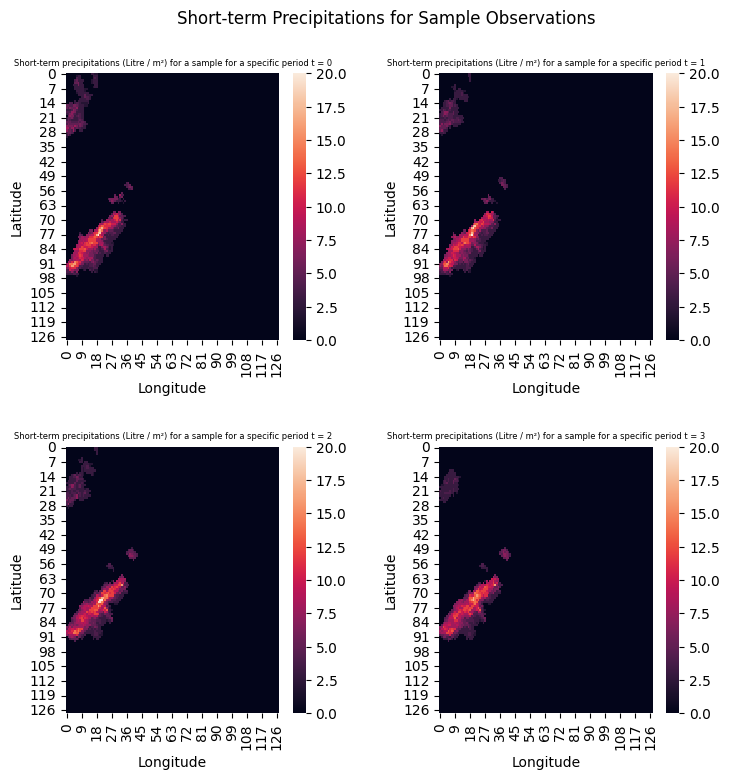

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),)
axs = axs.flatten()

for i, elem in enumerate(sample_observations.values()):
    sns.heatmap(elem, ax=axs[i],vmax=20)
    axs[i].set(xlabel='Longitude', ylabel='Latitude')
    axs[i].set_title(f"Short-term precipitations (Litre / m²) for a sample for a specific period t = {i}",fontdict={'fontsize': 6})

fig.suptitle("Short-term Precipitations for Sample Observations", fontsize=12)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

plt.show()


Typiquement, au vu de ce graphique, on voit que les précipitations en t=0 sont concentrées sur les positions à partir de (90,1) jusqu'à (65,40) du répère. Au fur et à mesure (si on observe t=1, t=2, t=3), on voit que la zone de précipitation s'assombrit légèrement dans le temps: En fait, il faut considérer que l'observation en t=0 est la plus récente et en t=3 est celle à - 18 minutes de la dernière observation

Finalement, pour traiter ces données, on devra mettre à plat sur une seule dimension de sorte à utiliser sans difficulté dans la modélisation, tel que chaque valeur de ce vecteur corresponde à  une observation à l'instant t d'un "kilomètre carré" particulier de la zone d'origine.


In [93]:
sample_1_flattened= sample_t_1.flatten()
sample_2_flattened = sample_t_2.flatten()
sample_3_flattened = sample_t_3.flatten()
sample_4_flattened = sample_t_4.flatten()

Ainsi, on a bien un point pour élement du plan d'origine (128*128 élements)

In [70]:
sample_t_1_flattened.shape

(16384,)

Finalement, l'input du modèle, pour chaque plan de 128km carré étudié sera une matrice de taille (16384,4) tel que chaque colonne correspond à une période observée (un lag) et chaque ligne correspond à un point dans le repère d'origine:

In [107]:
sample_input = np.stack((sample_1_flattened,sample_2_flattened,sample_3_flattened,sample_4_flattened),axis=1)

In [108]:
sample_input.shape

(16384, 4)